# VGG16

### Loading Libraries

In [98]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.layers import Dense, Flatten
from keras.models import Model
from keras.models import load_model
from keras.utils import image_dataset_from_directory
from sklearn.metrics import confusion_matrix,accuracy_score,classification_report
import seaborn as sns

from glob import glob
from tqdm import tqdm

### Loading the Data

In [2]:
data_dir = 'lung_colon_image_set/'

folders = glob(data_dir + '*')
print(folders)

images = glob(data_dir + '*/*.jpeg')
print('No. of Images: ', len(images))

['lung_colon_image_set/colon_aca', 'lung_colon_image_set/colon_n', 'lung_colon_image_set/lung_aca', 'lung_colon_image_set/lung_n', 'lung_colon_image_set/lung_scc']
No. of Images:  25000


### Plotting Sample Data

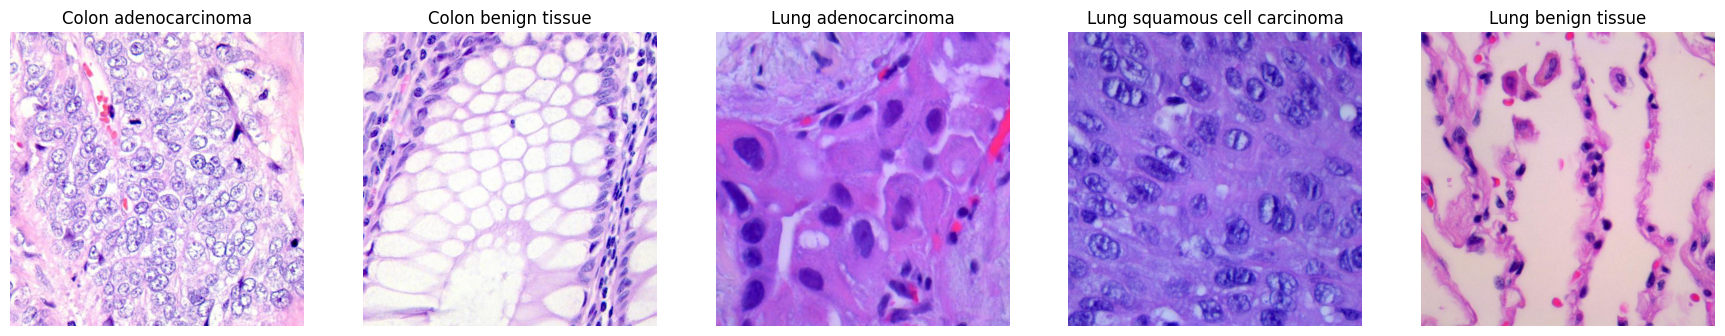

In [3]:
sample_imgs = ['lung_colon_image_set/colon_aca/colonca1.jpeg', 'lung_colon_image_set/colon_n/colonn1.jpeg', 'lung_colon_image_set/lung_aca/lungaca1.jpeg',
               'lung_colon_image_set/lung_scc/lungscc1.jpeg', 'lung_colon_image_set/lung_n/lungn1.jpeg']
titles = ['Colon adenocarcinoma', 'Colon benign tissue', 'Lung adenocarcinoma', 'Lung squamous cell carcinoma', 'Lung benign tissue']


plt.figure(figsize=(22, 8)) 
n = 1

for i in sample_imgs:
    plt.subplot(1, 5, n)
    plt.title(titles[n-1])
    plt.imshow(image.load_img(i))
    plt.axis('off')
    n += 1
plt.show()

### Splitting into Train-Test-Validation Sets

In [19]:
datagen = image.ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.3
    )

batch_size = 32

train_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='training'
)

val_generator = datagen.flow_from_directory(
    data_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    seed=42,
    subset='validation'
)

Found 17500 images belonging to 5 classes.
Found 7500 images belonging to 5 classes.


In [25]:
type(train_generator)

keras.src.preprocessing.image.DirectoryIterator

In [70]:
batch_size = 32

In [71]:
train_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset='training',
    seed=42,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 25000 files belonging to 5 classes.
Using 17500 files for training.


In [72]:
val_ds = image_dataset_from_directory(
    data_dir,
    validation_split=0.3,
    subset='validation',
    seed=42,
    image_size=(224, 224),
    batch_size=batch_size,
    label_mode='categorical'
)

Found 25000 files belonging to 5 classes.
Using 7500 files for validation.


In [73]:
num_of_batches = len(val_ds)

test_ds = val_ds.take(num_of_batches // 2)
val_ds = val_ds.skip(num_of_batches // 2)

### Building the Model

In [66]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freezing the weights of the pre-trained layers to ensure that they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Adding output layer
x = Flatten()(base_model.output)
x = Dense(1024, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
output = Dense(5, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [67]:
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

### Limiting GPU Memory Growth

In [7]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPU


### Training the Model

In [74]:
train_steps_per_epoch = len(train_ds)
test_steps_per_epoch = len(val_ds)

epochs = 10

history = model.fit(
    x=train_ds,
    steps_per_epoch=train_steps_per_epoch,
    epochs=epochs,
    validation_data=val_ds,
    validation_steps=test_steps_per_epoch,
    batch_size=32
)

Epoch 1/10


547/547 [==============================] - 164s 297ms/step - loss: 1.3503 - accuracy: 0.9323 - val_loss: 0.2929 - val_accuracy: 0.9481
Epoch 2/10
547/547 [==============================] - 164s 300ms/step - loss: 0.1138 - accuracy: 0.9759 - val_loss: 0.1380 - val_accuracy: 0.9742
Epoch 3/10
547/547 [==============================] - 165s 301ms/step - loss: 0.0841 - accuracy: 0.9850 - val_loss: 0.1131 - val_accuracy: 0.9760
Epoch 4/10
547/547 [==============================] - 165s 301ms/step - loss: 0.1281 - accuracy: 0.9833 - val_loss: 0.3303 - val_accuracy: 0.9617
Epoch 5/10
547/547 [==============================] - 165s 301ms/step - loss: 0.0767 - accuracy: 0.9890 - val_loss: 0.2340 - val_accuracy: 0.9771
Epoch 6/10
547/547 [==============================] - 165s 301ms/step - loss: 0.0547 - accuracy: 0.9903 - val_loss: 0.1100 - val_accuracy: 0.9827
Epoch 7/10
547/547 [==============================] - 165s 302ms/step - loss: 0.0319 - accuracy: 0.9946 - val_loss: 0.1032 - val_accura

In [75]:
hist = pd.DataFrame(history.history)
print(hist)

       loss  accuracy  val_loss  val_accuracy
0  1.350319  0.932343  0.292873      0.948083
1  0.113829  0.975943  0.138014      0.974175
2  0.084092  0.985029  0.113109      0.976038
3  0.128139  0.983257  0.330342      0.961661
4  0.076688  0.989029  0.234011      0.977103
5  0.054700  0.990343  0.109983      0.982694
6  0.031950  0.994571  0.103211      0.979499
7  0.022765  0.996057  0.071862      0.986954
8  0.001921  0.999486  0.085900      0.988019
9  0.027267  0.995886  0.140078      0.981896


In [82]:
model.save('my_model.h5')

### Model Evaluation

In [83]:
model = load_model('my_model.h5')

In [79]:
model.evaluate(test_ds)

2023-09-22 13:38:46.013694: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 392.00MiB (rounded to 411041792)requested by op model_1/block1_conv2/Relu
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-09-22 13:38:46.013759: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-09-22 13:38:46.013776: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 128, Chunks in use: 126. 32.0KiB allocated for chunks. 31.5KiB in use in bin. 3.6KiB client-requested in use in bin.
2023-09-22 13:38:46.013789: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 11, Chunks in use: 11. 6.0KiB allocated for chunks. 6.0KiB in use in bin. 5.6KiB client-requested in use in bin.
2023-09-22 13:38:46.013801: I tensor

ResourceExhaustedError: Graph execution error:

Detected at node 'model_1/block1_conv2/Relu' defined at (most recent call last):
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/traitlets/config/application.py", line 1043, in launch_instance
      app.start()
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start
      self.io_loop.start()
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 601, in run_forever
      self._run_once()
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once
      handle._run()
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue
      await self.process_one()
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one
      await dispatch(*args)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell
      await result
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request
      reply_content = await reply_content
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute
      res = shell.run_cell(
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell
      result = self._run_cell(
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell
      result = runner(coro)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_4616/383571708.py", line 1, in <module>
      model.evaluate(test_ds)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 2200, in evaluate
      logs = test_function_runner.run_step(
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 4000, in run_step
      tmp_logs = self._function(dataset_or_iterator)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1972, in test_function
      return step_function(self, iterator)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1956, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1944, in run_step
      outputs = model.test_step(data)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 1850, in test_step
      y_pred = self(x, training=False)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/training.py", line 569, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 512, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/functional.py", line 669, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1150, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call
      return self.activation(outputs)
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/activations.py", line 321, in relu
      return backend.relu(
    File "/home/amalcpauly/anaconda3/envs/tf/lib/python3.9/site-packages/keras/src/backend.py", line 5397, in relu
      x = tf.nn.relu(x)
Node: 'model_1/block1_conv2/Relu'
OOM when allocating tensor with shape[32,64,224,224] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node model_1/block1_conv2/Relu}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_test_function_93821]

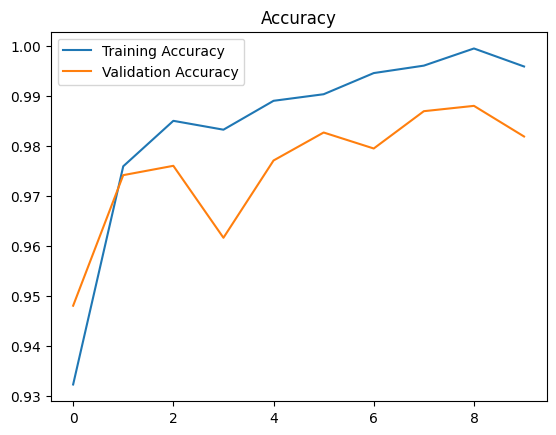

<Figure size 640x480 with 0 Axes>

In [84]:
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy')
plt.show()
plt.savefig('accuracy.png')

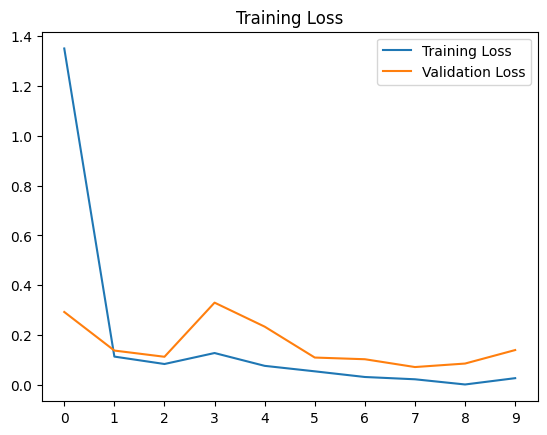

<Figure size 640x480 with 0 Axes>

In [85]:
x=list(range(0,10))
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.legend()
plt.xticks(x)
plt.title("Training Loss")
plt.show()
plt.savefig("loss.png")

1/1 [==============================] - 0s 38ms/step


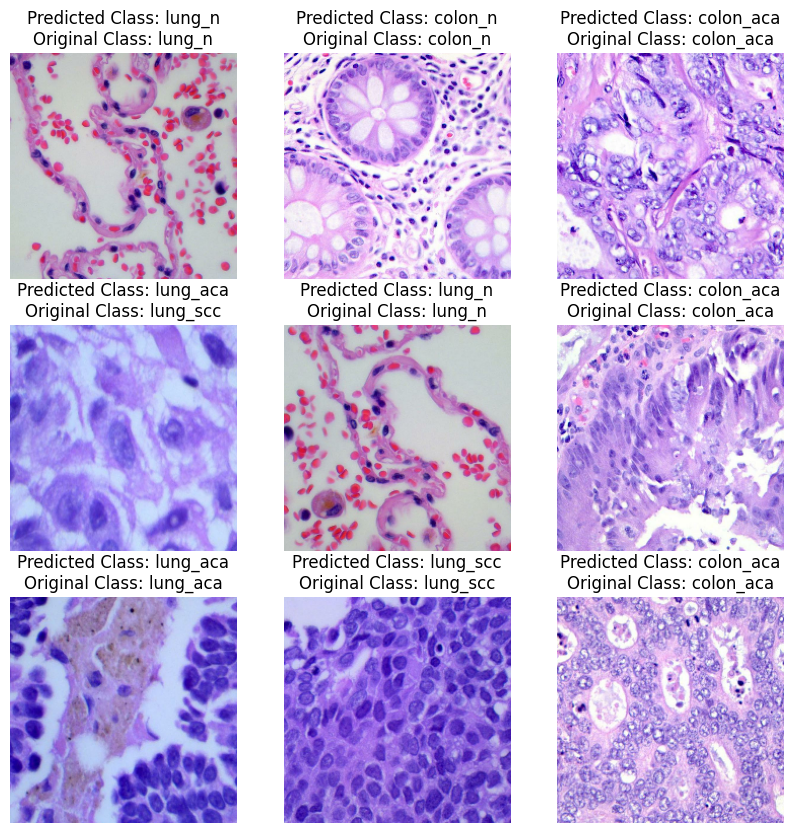

In [96]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in test_ds.take(1):
    make_predictions = model.predict(images)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        title = f"Predicted Class: {class_names[np.argmax(make_predictions[i])]}\nOriginal Class: {class_names[np.argmax(labels[i])]}"
        plt.title(title, fontsize=12, loc='center')
        plt.axis("off")

100%|██████████| 50/50 [05:59<00:00,  7.20s/it]


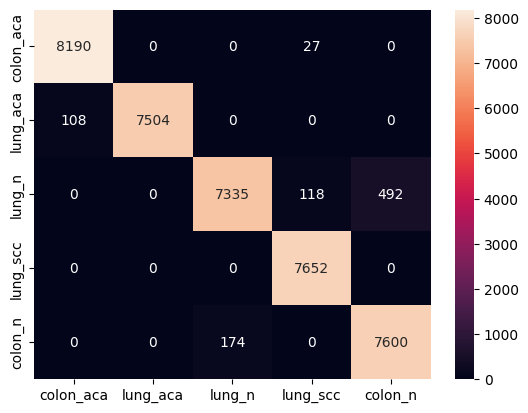

In [103]:
y_true = []
y_pred = []
for k in tqdm(range(50)):
    for images, labels in test_ds.take(k):
        make_predictions = model.predict(images, verbose=0)
        for i in range(32):
            y_pred.append(class_names[np.argmax(make_predictions[i])])
            y_true.append(class_names[np.argmax(labels[i])])

label = set(y_true)

sns.heatmap(confusion_matrix(y_true,y_pred),xticklabels=label,yticklabels=label,annot=True, fmt='d')
plt.show()